# "Knocking" Stocks

**Hypothesis:** People have a bias to prefer round numbers when making the decision
to sell a stock that they have been holding (for example, "I'll sell if it hits $200").

This isn't actually rational, as there's no reason to expect that a round number is the optimal value
at which to sell.

But if this is a trend, we ought to see evidence of it in stock prices "knocking" at round values.

In other words, they may approach a round number like $200, but continually fail to get very far past
it, as more people sell.

In [1]:
from polygon import RESTClient
import pandas as pd
from dotenv import load_dotenv
import os
load_dotenv()

API_KEY = os.getenv('POLYGON_API_KEY')

polygon_client = RESTClient(API_KEY)

/tmp/ipykernel_373111/1512348691.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from datetime import datetime
def agg_to_dict(agg):
    properties = ['close',
        'high',
        'low',
        'open',
        'otc',
        'transactions',
        'volume',
        'vwap']
    info = { key: getattr(agg, key) for key in properties }
    info['timestamp'] = datetime.utcfromtimestamp(agg.timestamp // 1000)
    return info

In [30]:
def get_stock_data(ticker):
    """Queries the Polygon API for two years worth of stock data for given ticker"""
    filepath = f'data/{ticker}.csv'
    if os.path.isfile(filepath):
        df = pd.read_csv(filepath)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    else: 
        timespan_size = 'day'
        multiple = 1 # Number of days betweeen results
        start_time = '2022-02-01'
        end_time = '2024-01-26'
        data = polygon_client.get_aggs(ticker, multiple, timespan_size, start_time, end_time)

        df = pd.DataFrame([agg_to_dict(day) for day in data])
        df.to_csv(filepath)
        return df

In [4]:
def find_local_maxes(df):
    """Finds all rows in which the stock price hits a local maximum"""
    return df.loc[df['high'] == df['high'].rolling(window=5, center=True).max()]

In [5]:
def find_potential_knocks(df, num_events=2, difference_factor=.05):
    """Find events where the local max has been near the same value multiple
    times in a row.
    
    `df`: The input data frame of all days of stock data

    `num_events`: The number of times a max must seem to repeat before the event
    is recorded

    `difference_factor`: The (multiplicative) factor used to determine if two
    local maxes are considered similar enough 
    (i.e. if `abs(M1 - M2) < M1 * difference_factor`)
    """

    df = find_local_maxes(df).sort_index()
    df = df.reset_index()

    def count_knocks(row):
        count = 1
        i = row.name + 1
        while i < len(df) and abs(df.iloc[i]['high'] - row['high']) < row['high'] * difference_factor:
            count += 1
            i += 1
        row['streak'] = count
        return row

    df['streak'] = 0
    df = df.apply(count_knocks, axis=1)
    return df[df['streak'] >= num_events]

In [31]:
nvda = get_stock_data('NVDA')
nvda

Unnamed: 0   close    high       low    open  otc  transactions  \
0             0  246.38  251.45  238.9001  251.04  NaN        699901   
1             1  252.42  258.17  245.5301  257.94  NaN        787625   
2             2  239.48  250.77  237.8000  244.58  NaN        589412   
3             3  243.19  246.35  236.3200  239.72  NaN        488979   
4             4  247.28  251.82  242.0200  243.72  NaN        500319   
..          ...     ...     ...       ...     ...  ...           ...   
494         494  596.54  603.31  590.7000  600.49  NaN        746831   
495         495  598.73  599.10  585.8500  595.70  NaN        506526   
496         496  613.62  628.49  599.3800  603.04  NaN        880162   
497         497  616.17  627.19  608.5000  623.50  NaN        772972   
498         498  610.31  617.83  605.7300  609.60  NaN        606908   

         volume      vwap           timestamp  
0    51891167.0  244.1687 2022-02-01 05:00:00  
1    54241941.0  251.5912 2022-02-02 05:00:00  
2    41017778.0  244.0767 2022-02-03 05:00:00  
3    35482850.0  242.2771 2022-02-04 05:00:00  
4    37686750.0  247.6307 2022-02-07 05:00:00  
..          ...       ...                 ...  
494  45275383.0  597.7673 2024-01-22 05:00:00  
495  29457445.0  594.7246 2024-01-23 05:00:00  
496  56027064.0  617.1761 2024-01-24 05:00:00  
497  48255184.0  619.0524 2024-01-25 05:00:00  
498  38974259.0  611.5168 2024-01-26 05:00:00  

[499 rows x 10 columns]

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


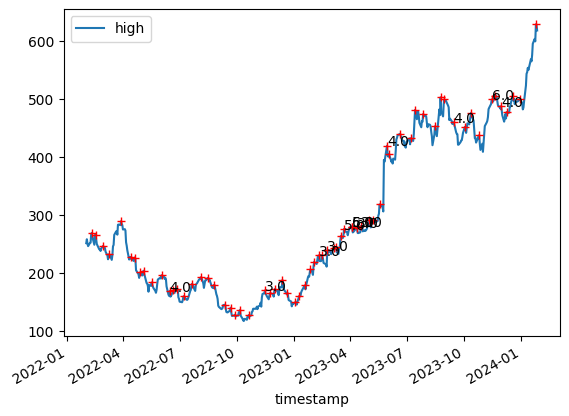

In [34]:
import matplotlib.pyplot as plt

def plot_knocks(df):
    fix, ax = plt.subplots()

    time_data = df[['timestamp', 'high']]
    print(type(time_data.iloc[0]['timestamp']))
    time_data = time_data.set_index('timestamp')
    time_data.plot(ax=ax)


    maxes = find_local_maxes(df)
    maxes = maxes[['timestamp', 'high']].set_index('timestamp')
    maxes.apply(lambda row: ax.plot(row.name, row.high, 'r+'), axis=1)

    knocks = find_potential_knocks(df, num_events=3).set_index('timestamp')
    knocks.apply(lambda row: ax.annotate(row.streak, (row.name, row.high)), axis=1)

plot_knocks(nvda)

In [50]:
import time

tickers = []

for i, ticker in enumerate(polygon_client.list_tickers(market='stocks', limit=1000)):
    tickers.append(ticker)
    if i % 1000 == 0:
        time.sleep(13) # Requests are limited to 5/min for free accounts
        print(i, ticker.ticker)

len(tickers)

0 A
1000 BBAX
2000 CLAR
3000 ED
4000 FTLF
5000 IBTF
6000 LEVI
7000 NNY
8000 PSApO
9000 SIEN
10000 TSVT
11000 XUSP


In [56]:
df = pd.DataFrame([{
    'ticker': t.ticker,
    'name': t.name
} for t in tickers])
df

ticker                                               name
0          A                          Agilent Technologies Inc.
1         AA                                  Alcoa Corporation
2        AAA                    AXS First Priority CLO Bond ETF
3       AAAU             Goldman Sachs Physical Gold ETF Shares
4       AACG   ATA Creativity Global American Depositary Shares
...      ...                                                ...
11124   ZVSA            ZyVersa Therapeutics, Inc. Common Stock
11125    ZWS             Zurn Elkay Water Solutions Corporation
11126   ZYME                                     Zymeworks Inc.
11127   ZYXI                                          ZYNEX INC
11128    ZZZ  Cyber Hornet S&P 500 and Bitcoin 75/25 Strateg...

[11129 rows x 2 columns]

In [58]:
df.to_csv('data/tickers.csv')

In [59]:
# Takes ~38 hours to fetch ~11,000 stock histories. Total ~334 megabytes
for i, t in enumerate(tickers):
    get_stock_data(t.ticker)
    time.sleep(12.1)
    if i % 100 == 0:
        print(i, t.ticker)

0 A
100 ACNB
200 AEVA
300 AIBBR
400 ALOT
500 AMUB
600 APTMU
700 ASA
800 ATOM
900 AWIN
1000 BBAX
1100 BEDZ
1200 BIAF
1300 BLD
1400 BOKF
1500 BSJQ
1600 BWAQR
1700 CART
1800 CDRpB
1900 CHAI
2000 CLAR
2100 CMRX
2200 CONXU
2300 CRNT
2400 CULP
2500 DALN
2600 DEUS
2700 DISTW
2800 DOYU
2900 DVYE
3000 ED
3100 EIX
3200 ENSV
3300 ESGRO
3400 EVO
3500 FAX
3600 FEBW
3700 FIHL
3800 FLUX
3900 FPL
4000 FTLF
4100 GANX
4200 GEOS
4300 GLLIU
4400 GOODN
4500 GSK
4600 HBANM
4700 HIFS
4800 HRB
4900 HYFI
5000 IBTF
5100 IGIC
5200 INAQW
5300 IPHA
5400 ITOS
5500 J
5600 JNPR
5700 KARB
5800 KNGZ
5900 KYN
6000 LEVI
6100 LNKB
6200 LVLU
6300 MBNE
6400 METC
6500 MJ
6600 MOON
6700 MSpO
6800 NAMS
6900 NEWTZ
7000 NNY
7100 NTRBW
7200 NWSA
7300 OCUL
7400 OPER
7500 OZ
7600 PCN
7700 PFS
7800 PL
7900 PPC
8000 PSApO
8100 PULT
8200 QLVD
8300 RBC
8400 REXR
8500 RMBL
8600 RSI
8700 SAEF
8800 SCHM
8900 SERA
9000 SIEN
9100 SLRC
9200 SNVpD
9300 SPNS
9400 SSL
9500 SURG
9600 TAOP
9700 TENK
9800 TIVC
9900 TPLC
10000 TSVT
10100 UCC
10200 